In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
from d2l import torch as d2l
import torch

# Attenction

The interation between queries and nonvolitiona cues. results in the attention pooling.
The attention pooling selectively aggregate values to produce the output.

As first pooling we could chose the most dumb approach, the avarage pooling over all the training outputs.

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

A better idea was proposed by Nadaraya and Watson to weigh the outputs $y_i$ according to their input locations:

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i = \sum_{i=1}^n \alpha(x, x_i) y_i,$$

where x is the query and $(x_i, y_i)$ is the key value pair.

If we consider a non parametric gaussian kernel we obtain:

$$\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}$$

A key $x_i$ closer to a given query x will gain more attenction via a larger attention weight assigned to the key's corresponding value $y_i$.
Of course we can easely add learnable parameters to the attention pooling.

The output of attention pooling is simply a weighted sum of the values based on the attention weights.

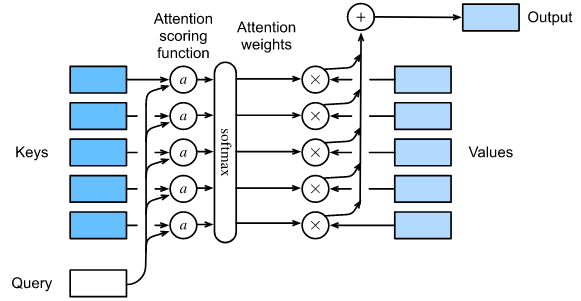


Mathematically speaking we can parametrize the problem of the $\alpha$ function throwght a scoring function $a$.

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$



In [ ]:
a = torch.rand(2, 4, 4)
b = torch.tensor([3,2])
#print(d2l.masked_softmax(a, b))
#print( a, b)
mask = torch.arange((3), dtype=torch.float32)[None, :] < b[:, None]
~mask, mask

(tensor([[False, False, False],
         [False, False,  True]]), tensor([[ True,  True,  True],
         [ True,  True, False]]))

## Additive attention scoring function

we use it when queries and keys are vectors of different lenghts

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R}$$

A toy example, where shapes (batch size, number of steps or sequence length in tokens, feature size) of queries, keys, and values are (2, 1, 20), (2, 10, 2), and (2, 10, 4), respectively. The attention pooling output has a shape of (batch size, number of steps for queries, feature size for values).



## Scaled dot product attention

If the queries and the keys have same shape (len d) a more efficent approach is the scaled dot-product attention scoring function. Assume that all the elements of the query and the key are independent random variables with zero mean and unit variance. The dot product of both vectors has zero mean and a variance of d. To ensure that the variance of the dot product still remains one regardless of vector length.

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}$$

## Bahdanau model

When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to parts of the input sequence that are relevant to the current prediction. This is achieved by treating the context variable as an output of attention pooling. 
$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

where the decoder hidden state $\mathbf{s}_{t' - 1}$ at time step ${t' - 1}$ is the query, and the encoder hidden states $\mathbf{h}_t$ are both the keys and values, and the attention weight $\alpha$ is computed using the additive attention scoring function.

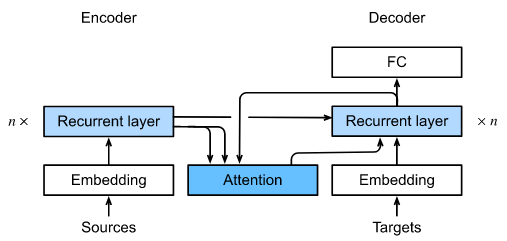

## Multi-Head attention

In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (e.g., shorter-range vs. longer-range) within a sequence. Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.

Each attention head is computed as:

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

f is attention pooling, such as additive attention and scaled dot-product attention. The multi-head attention output is another linear transformation via learnable parameters of the concatenation of heads.

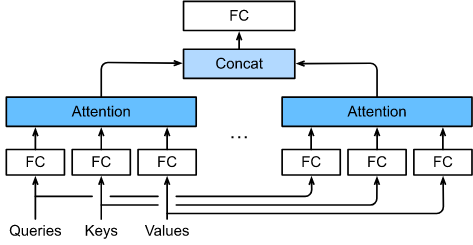



## Self attention

Imagine that we feed a sequence of tokens into attention pooling so that the same set of tokens act as queries, keys, and values. Specifically, each query attends to all the key-value pairs and generates one attention output. Since the queries, keys, and values come from the same place, this performs self-attention.

Given a sequence of input tokens $\mathbf{x}_1, \ldots, \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^d(1 \leq i \leq n)$, its self-attention outputs a sequence of the same length $\mathbf{y}_1, \ldots, \mathbf{y}_n$, where
$$
\mathbf{y}_i=f\left(\mathbf{x}_i,\left(\mathbf{x}_1, \mathbf{x}_1\right), \ldots,\left(\mathbf{x}_n, \mathbf{x}_n\right)\right) \in \mathbb{R}^d
$$

where

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$

In [ ]:
## 